<a href="https://colab.research.google.com/github/vvshyer/tensorflow2.0_learning/blob/master/tf_keras_to_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 39.6MB/s 
     |████████████████████████████████| 3.1MB 27.6MB/s 
     |████████████████████████████████| 501kB 34.7MB/s 
     |████████████████████████████████| 61kB 20.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0-beta0
sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
matplotlib 3.0.3
numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
tensorflow 2.0.0-beta0
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [0]:
!mkdir data

In [5]:
!ls

data  sample_data


In [7]:
!wget -P /content/data https://storage.googleapis.com/tf-datasets/titanic/train.csv

--2019-06-10 07:26:45--  https://storage.googleapis.com/tf-datasets/titanic/train.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30874 (30K) [application/octet-stream]
Saving to: ‘/content/data/train.csv’

train.csv           100%[===================>]  30.15K  --.-KB/s    in 0s      

2019-06-10 07:26:46 (85.7 MB/s) - ‘/content/data/train.csv’ saved [30874/30874]



In [8]:
!wget -P /content/data https://storage.googleapis.com/tf-datasets/titanic/eval.csv

--2019-06-10 07:27:05--  https://storage.googleapis.com/tf-datasets/titanic/eval.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13049 (13K) [application/octet-stream]
Saving to: ‘/content/data/eval.csv’

eval.csv            100%[===================>]  12.74K  --.-KB/s    in 0s      

2019-06-10 07:27:05 (75.3 MB/s) - ‘/content/data/eval.csv’ saved [13049/13049]



In [10]:
train_file = "./data/train.csv"
eval_file = "./data/eval.csv"

train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())
print(eval_df.head())

   survived     sex   age  ...     deck  embark_town  alone
0         0    male  22.0  ...  unknown  Southampton      n
1         1  female  38.0  ...        C    Cherbourg      n
2         1  female  26.0  ...  unknown  Southampton      y
3         1  female  35.0  ...        C  Southampton      n
4         0    male  28.0  ...  unknown   Queenstown      y

[5 rows x 10 columns]
   survived     sex   age  ...     deck  embark_town  alone
0         0    male  35.0  ...  unknown  Southampton      y
1         0    male  54.0  ...        E  Southampton      y
2         1  female  58.0  ...        C  Southampton      y
3         1  female  55.0  ...  unknown  Southampton      y
4         1    male  34.0  ...        D  Southampton      y

[5 rows x 10 columns]


In [11]:
y_train = train_df.pop('survived')
y_eval = eval_df.pop('survived')

print(train_df.head())
print(eval_df.head())
print(y_train.head())
print(y_eval.head())

      sex   age  n_siblings_spouses  parch  ...  class     deck  embark_town alone
0    male  22.0                   1      0  ...  Third  unknown  Southampton     n
1  female  38.0                   1      0  ...  First        C    Cherbourg     n
2  female  26.0                   0      0  ...  Third  unknown  Southampton     y
3  female  35.0                   1      0  ...  First        C  Southampton     n
4    male  28.0                   0      0  ...  Third  unknown   Queenstown     y

[5 rows x 9 columns]
      sex   age  n_siblings_spouses  parch  ...   class     deck  embark_town alone
0    male  35.0                   0      0  ...   Third  unknown  Southampton     y
1    male  54.0                   0      0  ...   First        E  Southampton     y
2  female  58.0                   0      0  ...   First        C  Southampton     y
3  female  55.0                   0      0  ...  Second  unknown  Southampton     y
4    male  34.0                   0      0  ...  Second     

In [12]:
train_df.describe() # 计算统计量

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [13]:
print(train_df.shape, eval_df.shape)

(627, 9) (264, 9)


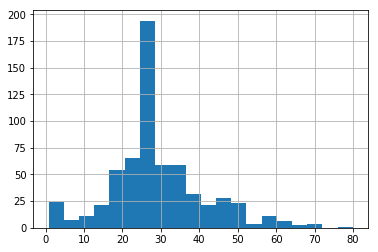

In [14]:
train_df.age.hist(bins = 20) # 直方图 20份 

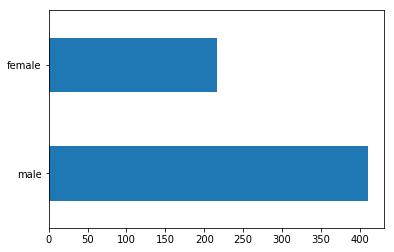

In [15]:
train_df.sex.value_counts().plot(kind = 'barh') # 横向barh 纵向barv

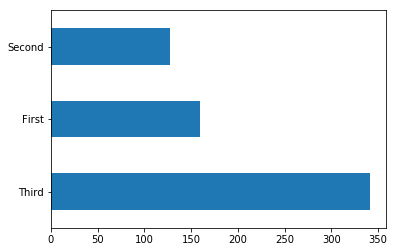

In [16]:
train_df['class'].value_counts().plot(kind='barh')

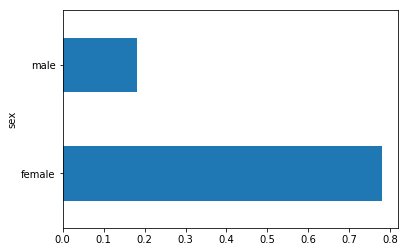

In [18]:
# 男女获救比例
pd.concat([train_df, y_train], axis = 1).groupby('sex').survived.mean().plot(kind='barh')

In [20]:
# 离散特征
categorical_columns = ['sex', 'n_siblings_spouses', 'parch', 'class',
                       'deck', 'embark_town', 'alone']
# 连续特征
numeric_columns = ['age', 'fare']

feature_columns = []
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))
    
for categorical_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            categorical_column, dtype = tf.float32))

sex ['male' 'female']
n_siblings_spouses [1 0 3 4 2 5 8]
parch [0 1 2 5 3 4]
class ['Third' 'First' 'Second']
deck ['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
embark_town ['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
alone ['n' 'y']


In [0]:
def make_dataset(data_df, label_df, epochs=10, shuffle=True,
                 batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

In [0]:
train_dataset = make_dataset(train_df, y_train, batch_size=5)

In [34]:
for x, y in train_dataset.take(1):
    print(x, y)

{'sex': <tf.Tensor: id=597, shape=(5,), dtype=string, numpy=array([b'female', b'female', b'male', b'female', b'female'], dtype=object)>, 'age': <tf.Tensor: id=589, shape=(5,), dtype=float64, numpy=array([28., 63., 28., 30., 28.])>, 'n_siblings_spouses': <tf.Tensor: id=595, shape=(5,), dtype=int32, numpy=array([1, 0, 0, 0, 0], dtype=int32)>, 'parch': <tf.Tensor: id=596, shape=(5,), dtype=int32, numpy=array([0, 0, 0, 0, 0], dtype=int32)>, 'fare': <tf.Tensor: id=594, shape=(5,), dtype=float64, numpy=array([15.5   ,  9.5875,  7.8958, 56.9292,  7.7333])>, 'class': <tf.Tensor: id=591, shape=(5,), dtype=string, numpy=array([b'Third', b'Third', b'Third', b'First', b'Third'], dtype=object)>, 'deck': <tf.Tensor: id=592, shape=(5,), dtype=string, numpy=array([b'unknown', b'unknown', b'unknown', b'E', b'unknown'], dtype=object)>, 'embark_town': <tf.Tensor: id=593, shape=(5,), dtype=string, numpy=
array([b'Queenstown', b'Southampton', b'Southampton', b'Cherbourg',
       b'Queenstown'], dtype=objec

In [35]:
# keras.layers.DenseFeature
for x, y in train_dataset.take(1):
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    print(keras.layers.DenseFeatures(age_column)(x).numpy())
    print(keras.layers.DenseFeatures(gender_column)(x).numpy())

[[28.]
 [63.]
 [28.]
 [30.]
 [28.]]
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [36]:
for x, y in train_dataset.take(1):
    print(keras.layers.DenseFeatures(feature_columns)(x).numpy())

[[28.      1.      0.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      1.      0.
  15.5     1.      0.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      0.      1.    ]
 [63.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   9.5875  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      0.      1.    ]
 [28.      0.      1.      1.      0.      0.      1.      0.      0.
   0.      0.      0.      0.      0.      1.      0.      0.      0.
   7.8958  0.      1.      0.      0.      0.      0.      0.      1.
   0.      0.      0.      0.      0.      1.      0.    ]
 [30.      0.      1.      0.      1.      0.      0.      0.      0.
   0.      0.      0.      0.      1.      0.      1.      0.      0.
  56.9292  0.      1.      0.      0.      0.      0.

In [0]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])

In [38]:
# 1. model.fit
# 2. model -> estimator -> train

train_dataset = make_dataset(train_df, y_train, epochs=100)
eval_dataset = make_dataset(eval_df, y_eval, epochs=1, shuffle=False)
history = model.fit(train_dataset,
                    validation_data = eval_dataset,
                    steps_per_epoch = 20,
                    validation_steps = 8, 
                    epochs = 100)

Epoch 1/100
20/20 [==============================] - 2s 88ms/step - loss: 1.7410 - accuracy: 0.5632 - val_loss: 0.6698 - val_accuracy: 0.6250
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.6251 - val_loss: 0.8322 - val_accuracy: 0.6016
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.8207 - accuracy: 0.6895 - val_loss: 0.6088 - val_accuracy: 0.7109
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6193 - accuracy: 0.6871 - val_loss: 0.5928 - val_accuracy: 0.6914
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6308 - accuracy: 0.6769 - val_loss: 0.5970 - val_accuracy: 0.6875
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6092 - accuracy: 0.6679 - val_loss: 0.5932 - val_accuracy: 0.6992
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6215 - accuracy: 0.6785 - val_loss: 0.6538 - val_accuracy: 0.6719
Epoch 8/100


W0610 08:00:55.479759 140675161786240 training_generator.py:235] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.



 0/20 [..............................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

In [39]:
estimator = keras.estimator.model_to_estimator(model)

# 1. function
# 2. return a. (features, labels) b. dataset -> (feature, label)
estimator.train(input_fn = lambda: make_dataset(train_df, y_train, epochs=100))

W0610 08:04:12.682246 140675161786240 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpt2rwejgb
W0610 08:04:12.694273 140675161786240 keras.py:564] You are creating an Estimator from a Keras model manually subclassed from `Model`, that was already called on some inputs (and thus already had weights). We are currently unable to preserve the model's state (its weights) as part of the estimator in this case. Be warned that the estimator has been created using a freshly initialized version of your model.
Note that this doesn't affect the state of the model instance you passed as `keras_model` argument.
W0610 08:04:12.705795 140675161786240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically bo

KeyError: ignored

In [0]:
# tensorflow框架bug 待修复